In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas import Series
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, LabelBinarizer, StandardScaler

%matplotlib inline

import warnings
# warnings.filterwarnings('ignore') # To ingnore warnings entirely
warnings.filterwarnings(action="once") # To see warning only once
TITANIC_PATH = "/home/zhach/code/scikit_ml/datasets/titanic/"

In [4]:
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lb = LabelBinarizer()
    def fit(self, X, y=None,**fit_params):
        return self.lb.fit(X)
    def transform(self, X):
        return self.lb.transform(X)

In [5]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [6]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        a = ["A" in s[0] for s in X]
        b = ["B" in s[0] for s in X]
        c = ["C" in s[0] for s in X]
        d = ["D" in s[0] for s in X]
        e = ["E" in s[0] for s in X]
        f = ["F" in s[0] for s in X]
        return np.c_[a, b, c, d, e, f]

In [7]:
tit_train = pd.read_csv(os.path.join(TITANIC_PATH, "train.csv"))
y_train = tit_train["Survived"]
X_train = tit_train.drop("Survived", axis=1)
tit_test = pd.read_csv(os.path.join(TITANIC_PATH, "test.csv"))
y_test = tit_test["Survived"]
X_test = tit_test.drop("Survived", axis=1)
print "Loaded Data into Program"

Loaded Data into Program


In [8]:
X_train.info()
X_train.head()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
replacement_value = X_train['Age'].mean()
X_train.fillna({'Age': replacement_value,
                'Embarked': '',
                'Cabin': ''
               }, inplace=True)
X_test.fillna({'Age': replacement_value,
                'Embarked': '',
                'Cabin': ''
               }, inplace=True)

In [11]:
num_attribs = ["Age", "SibSp", "Parch", "Fare"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cab_pipeline = Pipeline([
    ('selector', DataFrameSelector(["Cabin"])),
    ('attribs_adder', CombinedAttributesAdder()),
])

sex_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Sex'])),
    ('label_bin', CustomBinarizer()),
])

emb_pipeline = Pipeline([
    ('selector', DataFrameSelector(["Embarked"])),
    ('label_bin', CustomBinarizer()),
])

pc_pipeline = Pipeline([
    ('selector', DataFrameSelector(["Pclass"])),
    ('label_bin', CustomBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ("cab_pipeline", cab_pipeline),
    ('sex_pipeline', sex_pipeline),
    ('emb_pipeline', emb_pipeline),
    ('pc_pipeline', pc_pipeline),
])

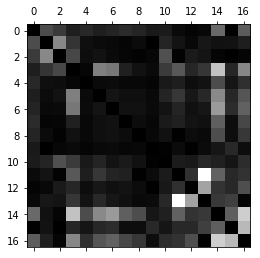

,Age,SibSp,Parch,Fare,Cabin A,Cabin B,Cabin C,Cabin D,Cabin E,Cabin F,Male,Embarked from Southampton,Embarked from Cherbourg,Embarked from Queenstown,P Class 1,P Class 2,P Class 3
0,0.000000,0.232625,0.179191,0.091566,0.121920,0.091394,0.113149,0.132319,0.115489,0.077209,0.084153,0.032024,0.013855,0.027121,0.319916,0.006589,0.281004
1,0.232625,0.000000,0.414838,0.159651,0.046266,0.034538,0.029251,0.017575,0.033751,0.001706,0.114631,0.059528,0.026354,0.070941,0.054582,0.055932,0.092548
2,0.179191,0.414838,0.000000,0.216225,0.040325,0.056498,0.030736,0.019125,0.011748,0.023694,0.245489,0.011069,0.081228,0.063036,0.017633,0.000734,0.015790
3,0.091566,0.159651,0.216225,0.000000,0.019549,0.386297,0.364318,0.098878,0.051749,0.033093,0.182333,0.269335,0.117216,0.166603,0.591711,0.118557,0.413333
4,0.121920,0.046266,0.040325,0.019549,0.000000,0.030880,0.034846,0.025663,0.025663,0.015923,0.078271,0.093040,0.040246,0.055383,0.231323,0.066756,0.144979
5,0.091394,0.034538,0.056498,0.386297,0.030880,0.000000,0.062841,0.046280,0.046280,0.028715,0.109689,0.168642,0.072579,0.123057,0.417160,0.120386,0.261450
6,0.113149,0.029251,0.030736,0.364318,0.034846,0.062841,0.000000,0.052225,0.052225,0.032403,0.058649,0.113952,0.049776,0.066995,0.470749,0.135851,0.295036
7,0.132319,0.017575,0.019125,0.098878,0.025663,0.046280,0.052225,0.000000,0.038462,0.023864,0.079248,0.102977,0.060318,0.051139,0.291218,0.041325,0.217282
8,0.115489,0.033751,0.011748,0.051749,0.025663,0.046280,0.052225,0.038462,0.000000,0.025699,0.054368,0.003376,0.039167,0.028520,0.235748,0.041325,0.169489
9,0.077209,0.001706,0.023694,0.033093,0.015923,0.028715,0.032403,0.023864,0.025699,0.000000,0.008202,0.034726,0.004113,0.033537,0.068833,0.122906,0.040721


In [42]:
full_pipeline.fit(X_train)
attribs = ["Age", "SibSp", "Parch", "Fare", 
           "Cabin A", "Cabin B", "Cabin C", "Cabin D", "Cabin E", "Cabin F", 
           "Male", 
           "Embarked from Southampton", "Embarked from Cherbourg", "Embarked from Queenstown",
           "P Class 1", "P Class 2", "P Class 3"
          ]
X_train_prepared = full_pipeline.transform(X_train)
X_train_prepared = np.c_[X_train_prepared[:,:11], X_train_prepared[:,12:]]
X_train_prepared_pd = pd.DataFrame(X_train_prepared)
X_train_prepared_pd.columns = attribs
corr_mat = X_train_prepared_pd.corr().abs().values
np.fill_diagonal(corr_mat, 0)
pd_t = pd.DataFrame(corr_mat)
pd_t.columns = attribs
plt.matshow(pd_t, cmap=plt.cm.gray)
plt.show()
pd_t
# X_train_prepared_pd.iloc[1]
# np.fill_diagonal(X_train_prepared_pd.corr().abs(), 0)

In [22]:
def please_precision_recall_f1(clf, X, y, cv):
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="macro")
    return precision, recall, f1

In [23]:
for_clf = RandomForestClassifier()
sgd_clf = SGDClassifier()
knn_clf = KNeighborsClassifier()

print "Forest Accuracy:", cross_val_score(for_clf, X_train_prepared, y_train, cv=5, scoring="accuracy").mean()
print "SGD Accuracy", cross_val_score(sgd_clf, X_train_prepared, y_train, cv=5, scoring="accuracy").mean()
print "KNN Accuracy", cross_val_score(knn_clf, X_train_prepared, y_train, cv=5, scoring="accuracy").mean()
print "Forest PRF1:", please_precision_recall_f1(for_clf, X_train_prepared, y_train, 5)
print "SGD PRF1", please_precision_recall_f1(sgd_clf, X_train_prepared, y_train, 5)
print "KNN PRF1", please_precision_recall_f1(knn_clf, X_train_prepared, y_train, 5)

Forest Accuracy: 0.808164481927
SGD Accuracy 0.708458936792
KNN Accuracy 0.793582281215
Forest PRF1: (0.75548589341692785, 0.70467836257309946, 0.78475966320324009)
SGD PRF1 (0.65349544072948329, 0.62865497076023391, 0.71195644154579396)
KNN PRF1 (0.75320512820512819, 0.6871345029239766, 0.77776693343743908)


In [24]:
attribs = ["Age", "SibSp", "Parch", "Fare", 
           "Cabin A", "Cabin B", "Cabin C", "Cabin D", "Cabin E", "Cabin F", 
           "Male", 
           "Embarked from Southampton", "Embarked from Cherbourg", "Embarked from Queenstown",
           "P Class 1", "P Class 2", "P Class 3"
          ]
best_feats = [""]
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared = np.c_[X_test_prepared[:,:11], X_test_prepared[:,12:]]

for_clf.fit(X_train_prepared, y_train)
y_pred = for_clf.predict(X_test_prepared)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
print accuracy, precision, recall, f1
sorted(zip(for_clf.feature_importances_, attribs), reverse=True)

0.796650717703 0.721854304636 0.717105263158 0.779998637762


[(0.24139137244126338, 'Age'),
 (0.23093160907351282, 'Male'),
 (0.21869790481493787, 'Fare'),
 (0.084350216255038191, 'P Class 3'),
 (0.046078458368085065, 'SibSp'),
 (0.035456704436973671, 'Parch'),
 (0.02785026731503178, 'P Class 1'),
 (0.019245055621398922, 'Embarked from Southampton'),
 (0.017964082776884785, 'Embarked from Queenstown'),
 (0.01374531928994871, 'Cabin E'),
 (0.013734203667651056, 'Embarked from Cherbourg'),
 (0.012221848526579546, 'Cabin B'),
 (0.011267560547926402, 'Cabin C'),
 (0.0099229336663017448, 'P Class 2'),
 (0.0083570712674380307, 'Cabin D'),
 (0.0054073309377985516, 'Cabin F'),
 (0.0033780609932295043, 'Cabin A')]